In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from tabulate import tabulate

2024-03-21 11:20:39.122346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 11:20:39.816101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 22})

# Data Preperation

In [4]:
datapath = 'data_HH_T1/rho50[kgm3].csv'

In [5]:
n = pd.read_csv(datapath, index_col=0, parse_dates=True).dropna()
da = n.iloc[:,0]
fl = n.iloc[:,1]

### Plot raw data with Anomalies

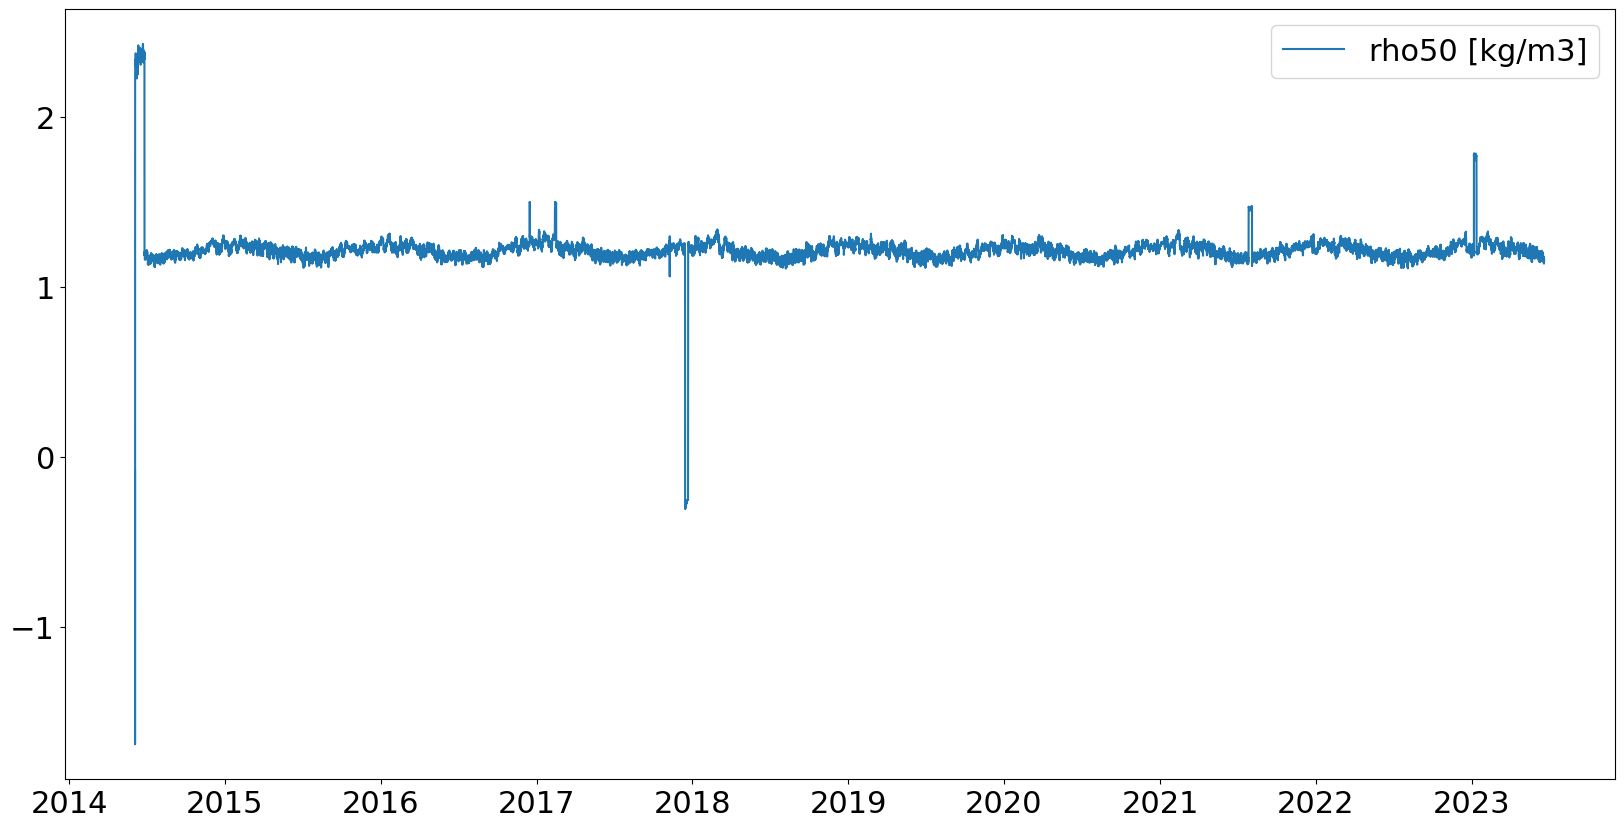

In [6]:
plt.plot(da, label=da.name)
plt.legend()
plt.show()

### cast setted flags to True/False (use value_counts() to see wich flags where used)

### y_true only used later in training process to just train with anomaly free data

In [10]:
fl.value_counts()

rho50_f
900000    458139
900002      9850
900001      6392
910000       625
910001        35
910002         5
920000         2
Name: count, dtype: int64

In [9]:
y_true = pd.DataFrame(fl).applymap(lambda x: (x == 900000) or (x == 900001) or (x == 910000) or (x == 910001))
y_true = ~y_true
y_true

rho50_f
Date Time                   
2014-06-04 14:00:00     True
2014-06-04 14:10:00     True
2014-06-04 14:20:00     True
2014-06-04 14:30:00     True
2014-06-04 14:40:00     True
...                      ...
2023-06-19 23:20:00    False
2023-06-19 23:30:00    False
2023-06-19 23:40:00    False
2023-06-19 23:50:00    False
2023-06-20 00:00:00    False

[475048 rows x 1 columns]

# Trainstep (can be skipped, if a model exist)

In [11]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy().flatten()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [14]:
WINDOW_SIZE = 100
X,y = df_to_X_y(pd.DataFrame(da)[~y_true.rename(columns={fl.name: da.name})].dropna(), WINDOW_SIZE)
X.shape, y.shape

((465091, 100), (465091,))

In [15]:
min_val_X = X.min()
max_val_X = X.max()

min_val_y = y.min()
max_val_y = y.max()

X = (X - min_val_X) / (max_val_X - min_val_X)
y = (y - min_val_y) / (max_val_y - min_val_y)

In [16]:
X_train, y_train = X[:200000], y[:200000]
X_val, y_val = X[200000:400000], y[200000:400000]
X_test, y_test = X[400000:], y[400000:]

In [19]:
X_test

array([[0.54407295, 0.54711246, 0.54494138, ..., 0.54233608, 0.53886235,
        0.53191489],
       [0.54711246, 0.54494138, 0.55145462, ..., 0.53886235, 0.53191489,
        0.5267043 ],
       [0.54494138, 0.55145462, 0.55319149, ..., 0.53191489, 0.5267043 ,
        0.53017803],
       ...,
       [0.27920104, 0.26096396, 0.26313504, ..., 0.22058185, 0.22318715,
        0.2244898 ],
       [0.26096396, 0.26313504, 0.28093791, ..., 0.22318715, 0.2244898 ,
        0.22535823],
       [0.26313504, 0.28093791, 0.26704299, ..., 0.2244898 , 0.22535823,
        0.22535823]])

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [21]:
model = Sequential()
model.add(InputLayer((WINDOW_SIZE, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=.0001), 
              metrics=[RootMeanSquaredError()])

In [97]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=2)

Epoch 1/2
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 142s 23ms/step - loss: 1.4855e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.6962e-05 - val_root_mean_squared_error: 0.0041
Epoch 2/2
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 146s 23ms/step - loss: 1.4354e-05 - root_mean_squared_error: 0.0038 - val_loss: 1.4413e-05 - val_root_mean_squared_error: 0.0038


In [99]:
model.save("model/model.keras")

# Load Model

In [100]:
import keras
model = keras.models.load_model("model/model.keras")

In [31]:
X_all,y_all = df_to_X_y(da, WINDOW_SIZE)

In [32]:
min_val_X_all = X_all.min()
max_val_X_all = X_all.max()

min_val_y_all = y_all.min()
max_val_y_all = y_all.max()

X_all_scaled = (X_all - min_val_X_all) / (max_val_X_all - min_val_X_all)
y_all_scaled = (y_all - min_val_y_all) / (max_val_y_all - min_val_y_all)

In [90]:
predictions = model.predict(X_all_scaled).flatten()
results = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y_all_scaled.flatten()})

14843/14843 ━━━━━━━━━━━━━━━━━━━━ 102s 7ms/step


In [40]:
new = pd.DataFrame(results)
new.index = pd.to_datetime(da.index[:predictions.size])

### some tests if predictions and real data are the same (without the anomalies)

In [34]:
import seaborn as sns

(0.6, 0.8)

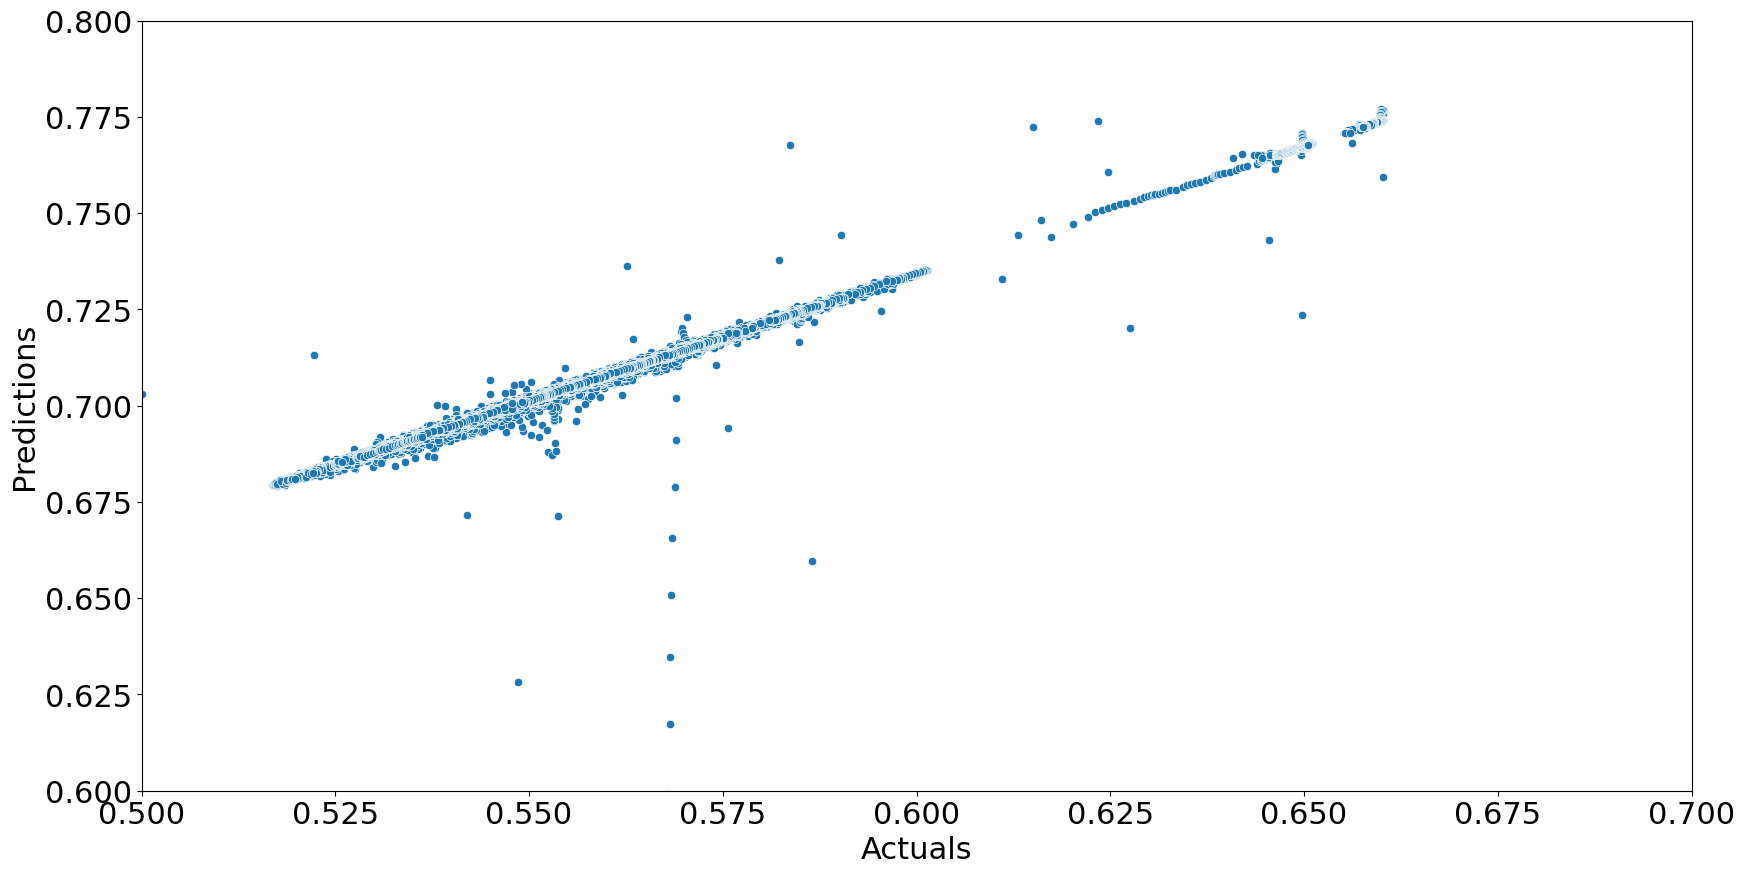

In [47]:
plot = sns.scatterplot(data=results, x="Actuals", y="Predictions")
plot.set_xlim(.5, .7)
plot.set_ylim(.6, .8)

In [48]:
r = np.corrcoef(results['Actuals'], results['Predictions'])
r

array([[1.        , 0.99930405],
       [0.99930405, 1.        ]])

In [49]:
me = [["Mean squared error", mean_squared_error(results['Actuals'], results['Predictions'])],
      ["Mean absolute error", mean_absolute_error(results['Actuals'], results['Predictions'])]]
print(tabulate(me))

-------------------  ---------
Mean squared error   0.0223315
Mean absolute error  0.14864
-------------------  ---------


# Anomaly Detection

### version with Moving Average

In [52]:
new['res'] = abs(new['Predictions'] - new['Actuals'])
new['Moving average res'] = new['res'].shift(-1000).rolling(window=2001).mean()

In [61]:
factor = 1.1

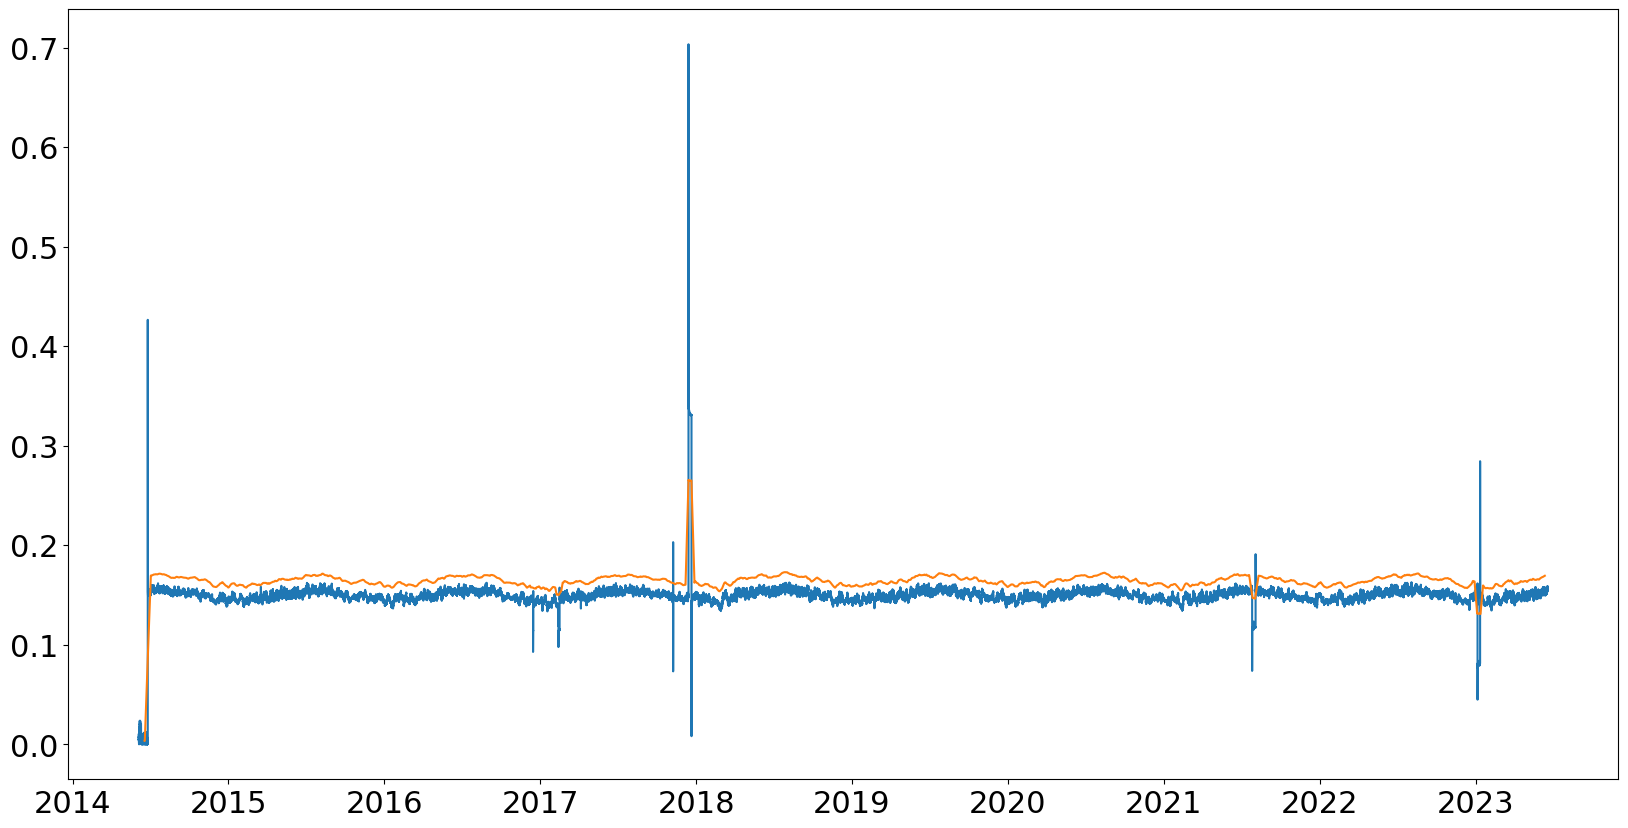

In [62]:
plt.plot(new['res'])
plt.plot(factor * new['Moving average res'])
# plt.ylim([0, .1])

In [68]:
new['Anomaly'] = new['res'] > (factor * new['Moving average res'])

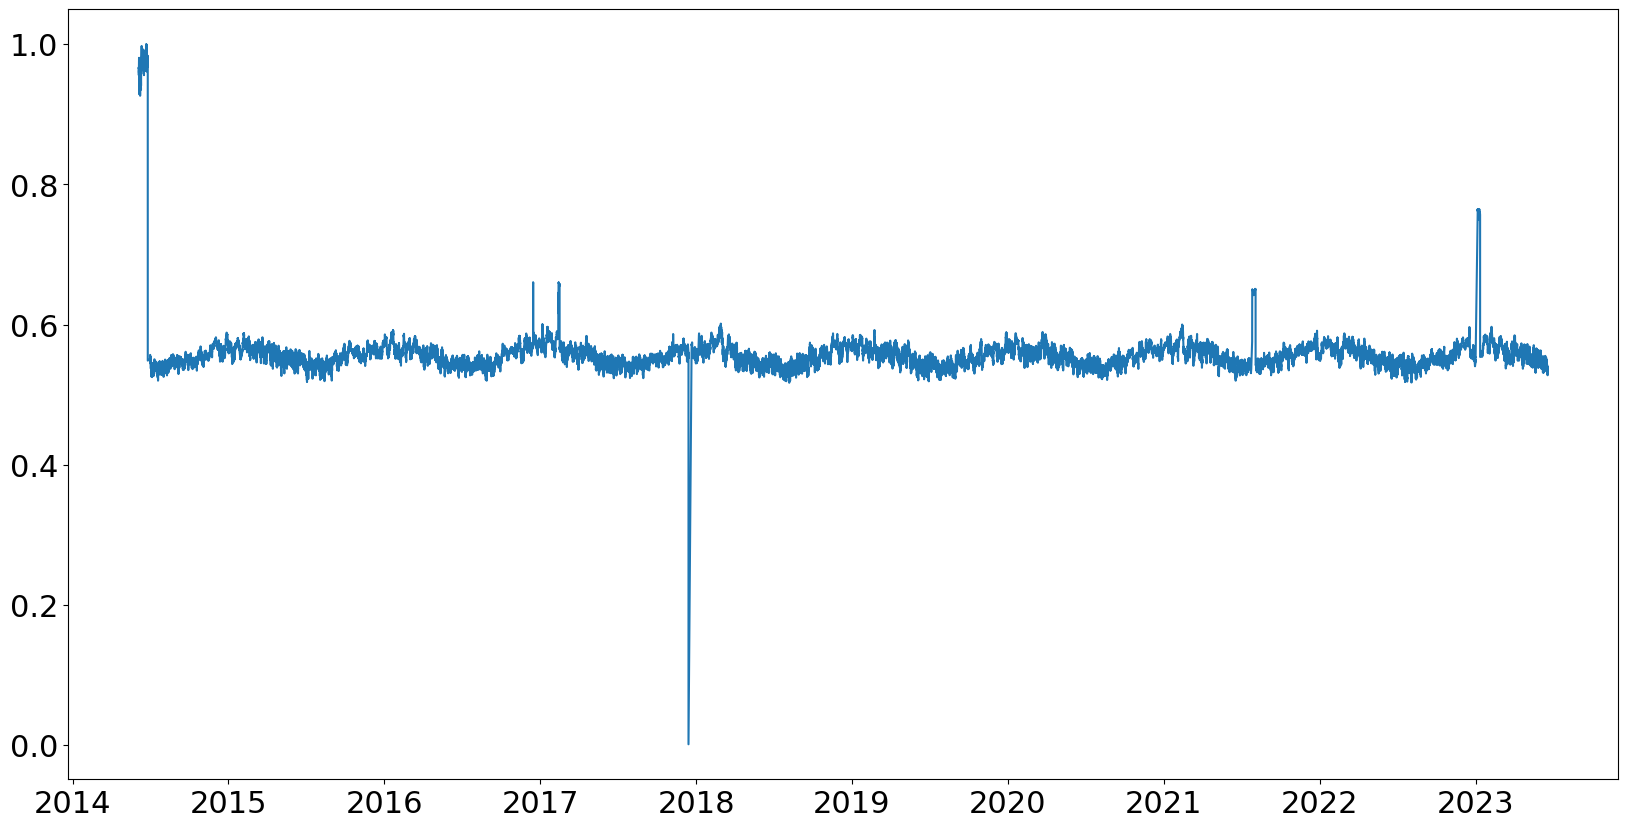

In [78]:
plt.plot(new['Actuals'][new['Anomaly']==0])

## Final Dataframe with original Values and Anomaly column (True for Anomaly)

In [81]:
new[['Actuals', 'Anomaly']]

Actuals  Anomaly
Date Time                             
2014-06-04 14:00:00  0.966602    False
2014-06-04 14:10:00  0.966895    False
2014-06-04 14:20:00  0.966602    False
2014-06-04 14:30:00  0.966565    False
2014-06-04 14:40:00  0.966015    False
...                       ...      ...
2023-06-19 06:40:00  0.535799    False
2023-06-19 06:50:00  0.535909    False
2023-06-19 07:00:00  0.535983    False
2023-06-19 07:10:00  0.535983    False
2023-06-19 07:20:00  0.536129    False

[474948 rows x 2 columns]